# Asennusten maantieteellistä klusterointia

* Pyritään luomaan asennusten määrien ja sijaintien perusteella maantieteellisiä klustereita.
* Klusteroinnissa käytetään kullekin postinumerolle erillisestä csv-tiedostosta sijaintiedoksi haettuja koordinaatteja lat ja lon.
* Visualisoidaan luotuja klustereita ja asennusten dataa erilaisilla kuvaajilla pääasiassa kartalla.

### Klusterointimenetelmäksi valikoitui DBSCAN, koska
* halutaan luoda klustereita nimenomaan asennusten määrien perusteella
* klusterien määrää ei haluta etukäteen asettaa, kuten monissa muissa malleissa tehdään (esim. Kmeans)
* kaikkia asennuksia ei haluta sisällyttää klustereihin, vaan mallissa karsitaan ns. outliereita
* näkyvä tulos menetelmän ajamiseen käytettyyn aikaan suhteutettuna vaikutti tarkoitukseen sopivimmalta verrattuna muihin (OPTICS, HDSCAN) vastaavalla periaattella kokeiltuihin 

### Pohdittavaa jatkossa

* Onko tällaisen klusteroinnin tuloksia mitenkään mahdollista konkreettisesti arvioida?
* Antaako klusteroinnin käyttäminen mitään lisäarvoa? Sinälläänhän tässä vain luodaan tiheitä alueita, jotka ovat oikeastaan jo olemassa datassa kaupunkien muodossa.
* Millä perusteella klusteroinnissa käytettäviä parametreja (dbscanissa eps ja min_samples) olisi mahdollista säätää optimaalisiksi? 
* Olisiko mahdollista painottaa tuloksia esim. asennuksen hinnan/koon perusteella (sample_weights parametri), jolloin arvokkaammat asennukset nostaisivat jotenkin klusterissa arvoa?

Linkkejä:

* https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
* https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html
* https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html
* https://towardsdatascience.com/geospatial-clustering-kinds-and-uses-9aef7601f386
* https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html
* https://www.analyticsvidhya.com/blog/2020/02/4-types-of-distance-metrics-in-machine-learning/
* https://medium.com/@saurabh.dasgupta1/understanding-the-epsilon-parameter-of-dbscan-clustering-algorithm-fe85669e0cae

## Datan haku ja esikäsittely

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint
import importlib.util
import sys

try:
  import preprocessor as esik
except ModuleNotFoundError:
  file_path = "../Tehtava-03/preprocessor.py"; module_name = "preprocessor"; spec = importlib.util.spec_from_file_location(module_name, file_path)
  esik = importlib.util.module_from_spec(spec); sys.modules[module_name] = esik; spec.loader.exec_module(esik)

# ajetaan esikäsittelijä valittuihin sarakkeisiin
cols = ['installation_date', 'year', 'zip_code', 'city', 'state', 'customer_segment', 'system_size_DC', 'total_installed_price', 'price_per_kW']
df_all = esik.esik(cols, 'common') # minimal tai common, commonilla hinta ja teho esikäsitellään tarkemmin

# hieman lisää esikäsittelyjä
df_all = df_all[(df_all['state'] == 'CA')] # vain Californian alue
df_all = df_all[pd.to_numeric(df_all['zip_code'], errors='coerce').notnull()] # pudotetaan ei-numeeriset zip-koodit sekä nolla-arvot (zip+4)
df_all =  df_all[(df_all['zip_code'].astype(int) < 96137) & (df_all['zip_code'].astype(int) > 90001)] # poistetaan muita virheellisiä zip-koodeja
df_all['city'] = df_all['city'].str.lower().str.title() # normalisoidaan sijainnit: ensin pieneksi ja sitten jokainen sana isolla
df_all = df_all.dropna(subset=['total_installed_price', 'system_size_DC', 'zip_code', 'city']) # pudotetaan lisää nan-arvoja pois

# csv-tiedosto, josta saadaan lat ja lon koordinaatit zip-koodeille
# https://gist.github.com/abatko/ee7b24db82a6f50cfce02afafa1dfd1e ja alkuperäinen lähde US CENSUS data https://www.census.gov/geographies/reference-files/time-series/geo/gazetteer-files.html
df2 = pd.read_csv('../data/zip_lat_lon_2018.csv', sep=',', usecols=['ZIP', 'LAT', 'LNG'], dtype={'ZIP': 'object'})
df2.columns = ['zip_code', 'lat', 'lon'] # nimetään sarakkeet uudelleen
df_all = pd.merge(df_all, df2).sort_index() # yhdistetään lisädata zip_koodin perusteella

# aikavälin ja asiakassegmentin määritys
date_range = {'start':'1998-01-01', 'end':'2019-12-31'}
customer_segment = 'RES' # RES or NONRES

df_all = df_all[(df_all['installation_date'] > date_range['start']) & (df_all['installation_date'] <= date_range['end'])]
df_all = (df_all[df_all['customer_segment'].isin(['RES'])]) if customer_segment == 'RES' else (df_all[~df_all['customer_segment'].isin(['RES'])])

dfd = df_all[['system_size_DC', 'total_installed_price', 'price_per_kW']].describe()
dfd

system_size_DC  total_installed_price   price_per_kW
count   623286.000000           6.232860e+05  623286.000000
mean         6.045000           2.701901e+04    4635.439561
std          5.002174           2.336806e+04    2242.557155
min          0.240000           1.000000e+03    1000.000000
25%          3.850000           1.650000e+04    3674.184585
50%          5.355000           2.388000e+04    4500.000000
75%          7.420000           3.323100e+04    5120.000000
max       1097.555000           2.976760e+06  823842.151675

## Klusterointi sklearn.DBSCAN

* DBSCAN on erityisesti `määrällisen datan klusterointiin` soveltuva koneoppimisen menetelmä
* Mahdollista hyödyntää myös maantieteelliseen dataan
* Klusterien lukumäärää ei tarvitse etukäteen määrittää
* Suodattaa ja merkitsee klustereihin kuulumattomat arvot outliereiksi (noise)
* Parametri `eps` eli epsilon määrittää säteen, miltä alueelta muita pisteitä kullekin asennukselle etsitään
* Parametri `min_samples` määrittää lukumäärän, joka vähintään vaaditaan, että klusteri muodostetaan

Klustereiden määrä: 107
Klusteroituja asennuksia: 326420
Klusteroimattomia asennuksia: 296866
Asennuksia yhteensä: 623286


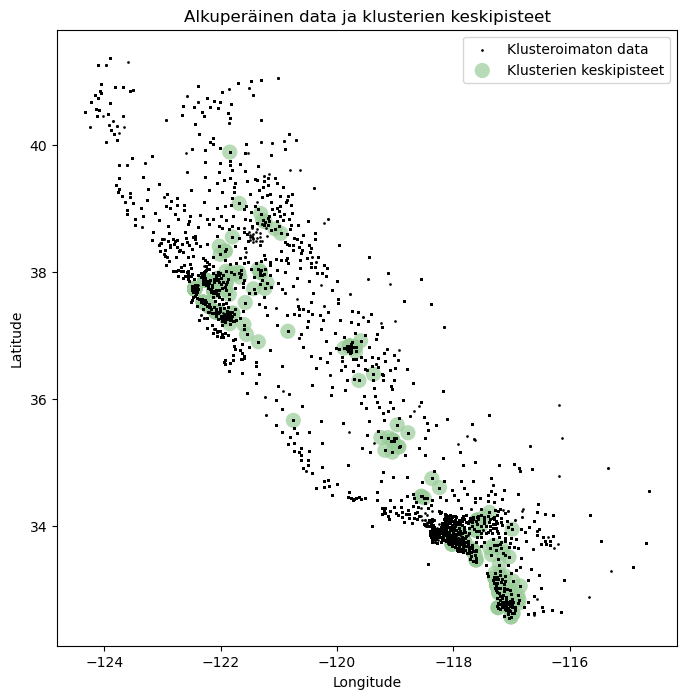

In [3]:
df = df_all.copy()

# poimitaan koordinaatit erikseen
coords = df[['lat','lon']].to_numpy()
X = np.radians(coords)

# myös näitä tarvitaan DBSCANin ajamiseen
earth_radius_km = 6371.0088
epsilon = 5 / earth_radius_km
samples = 1600

# Ajetaan DBSCAN, luodaan lista klustereista annettujen koordinaattien perusteella
db = DBSCAN(eps=epsilon, min_samples=samples, algorithm='ball_tree', metric='minkowski', p=2) #p=1 manhattan, p=2 euclidean
db.fit(X)

# klustereiden otsikot: joko -1 (=ei kuulu klustereihin) tai klusterin numero
cluster_labels = db.labels_
n_clusters = len(set(cluster_labels)) # määrä

cluster_arrays = pd.Series([coords[cluster_labels == n] for n in range(-1, n_clusters-1)]) # tallennetaan klusterit arrayhin 
clusters = pd.DataFrame(cluster_arrays).explode(0).rename(columns={0:'loc'}) # luodaan dataframe, jossa kukin klusteri omaksi rivikseen
clusters['cluster'] = clusters.index # tätä tarvitaan klusterin tunnistamiseen
clusters['loc'] = clusters['loc'].apply(tuple)
clusters.drop_duplicates(subset=['loc'], inplace=True)
df['loc'] = list(zip(df['lat'], df['lon']))
df = pd.merge(df, clusters, on='loc') # liitetään klusteridata alkuperäiseen dataframeen

# funktio palauttaa koordinaateista lasketun keskipisteen
def get_center_point(cluster):
    points = MultiPoint(cluster)
    return points.centroid.coords[0] #True centroid

# dbscan ei palauta keskipisteitä suoraan, kootaan ne erikseen
center_points = cluster_arrays.map(get_center_point)
lats, lons = zip(*center_points)
centroids = pd.DataFrame({'lon_c':lons, 'lat_c':lats})
centroids['cluster'] = centroids.index # tätä tarvitaan klusterin tunnistamiseen
df = pd.merge(df, centroids) # liitetään keskipisteet alkuperäiseen dataframeen

df['zip_city'] = list(zip(df['city'], df['zip_code'])) #tarkentava zip-koodin ja sijainnin nimen yhteinen sarake
df['cluster'] = df['cluster'].astype('category') # määritetään clusterin id kategoriseksi

dfc = df.copy() # klusteroitu dataframe talteen

print('Klustereiden määrä:', len(df['cluster'].unique())-1) # nollaa ei lasketa mukaan
print('Klusteroituja asennuksia:', len(df[df['cluster'] != 0]))
print('Klusteroimattomia asennuksia:', len(df[df['cluster'] == 0]))
print('Asennuksia yhteensä:', len(df))

df = df[df['cluster'] != 0]
df.drop_duplicates(subset=['loc'], inplace=True)

fig, ax = plt.subplots(figsize=[8, 8])
df_scatter = ax.scatter(df['lon_c'], df['lat_c'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_all_scatter = ax.scatter(df_all['lon'], df_all['lat'], c='k', alpha=0.9, s=1)
ax.set_title('Alkuperäinen data ja klusterien keskipisteet')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_all_scatter, df_scatter], ['Klusteroimaton data', 'Klusterien keskipisteet'], loc='upper right')
plt.show()

## Klusteroidut ja klusteroimattomat asennukset kartalla

* Klusterit eritellään kartalla väreittäin
* Klustereihin kuuluvat zip-koodit näytetään erikseen omina ympyröinään 
* Näytetään myös klustereihin kuulumattomat (cluster=0) pieninä tummina pisteinä

In [4]:
df = dfc.copy() # käytetään ryhmittelemätöntä klusteroitua dataframea

df['cluster_size'] = df.groupby('cluster')['cluster'].transform('count') #lasketaan klusterin koko
df['zip_city_size'] = (df.groupby('zip_city')['zip_city'].transform('count')) # kartalla
df['zip_city_size'] = df['zip_city_size'].mask(df['cluster'] == 0, 50) # klustereihin kuulumattomat (=0) muutetaan kokoa, jotta näkyvät myös kartalla
df.drop_duplicates(subset=['loc'], inplace=True) #samaan kohtaan ei tarvitse useampaa pistettä

fig = px.scatter_mapbox(df, 
                        lat=df['lat'], lon=df['lon'],
                        hover_name='zip_city',
                        size='zip_city_size',
                        size_max = 20,
                        color='cluster',
                        zoom=5.5, 
                        hover_data={'cluster':True, 'cluster_size': True, 'lat':False, 'lon':False},
                        mapbox_style='carto-positron',
                        center = {'lat': 36.778259, 'lon': -119.417931}, #kartan keskitys Californiaan
                        opacity=0.8
                        )            
fig.update_layout(autosize=False, 
                margin={"r":0,"t":40,"l":0,"b":0}, 
                width=800, height=800,
                title='Aurinkopaneelijärjestelmien <b>asennusten määrä ja asennuksen keskimääräinen hinta.</b><br>(Kuluttaja-asiakkaat, California, 1998-2019)'
                )
fig.show()

## Asennusmäärien mukaan 20 isointa klusteria kartalla

* Kukin klusteri on erillinen ympyrä kartalla
* Ympyrän koko kertoo asennusten määrän ja väri keskimääräisen asennuksen hinnan

In [5]:
df = dfc.copy()

# Ryhmitellään dataa
df = df.groupby('cluster').agg({'city': lambda x: list(set(x)), 'installation_date':'count', 'price_per_kW':'mean', 'total_installed_price': 'sum', 'system_size_DC': 'mean', 'lat_c':'first', 'lon_c':'first'}).reset_index()
df = df[df['cluster'] != 0] # klustereihin kuulumattomia pisteitä ei näytetä

# muutetaan ja lisätään joitain sarakkeita
df = df.rename(columns={'installation_date':'installation_count'})
df['average_price'] = (df['total_installed_price'] / df['installation_count']).round(0)
df[['system_size_DC']] = df[['system_size_DC']].round(2)
df[['price_per_kW']] = df[['price_per_kW']].round(2)
df = df.sort_values('installation_count', ascending=0)

dfg = df.copy() # ryhmitelty dataframe talteen
display(dfg.head(20))

cluster                                               city  \
12      12  [Chula Vista, Lemon Grove, San Diego, Spring V...   
23      23             [Del Mar, Santa Ana, San Diego, Poway]   
10      10  [Santa Clara, Campbell, Los Gatos, Fremont, Sa...   
15      15  [Pinedale, Los Banos, Kerman, Three Rivers, Fr...   
94      94  [Lakewood, Bellflower, Westminster, Cerritos, ...   
40      40  [Albany, Berkeley, El Sobrante, San Pablo, El ...   
19      19  [Daly City, San Francisco, Irvine, Brisbane, S...   
38      38  [Robinson Ranch, Rancho Santa Margarita, Missi...   
65      65  [San Diego, Encinitas, Olivenhain, Cardiff, Le...   
16      16      [Rancho La Costa, Carlsbad, Vista, Oceanside]   
69      69              [El Dorado, Rocklin, El Dorado Hills]   
26      26                  [Brentwood, Byron, San Francisco]   
82      82                                   [Clovis, Fresno]   
4        4                                          [Lincoln]   
56      56                                      [Bakersfield]   
80      80  [Cowan Heights, North Tustin, Fountain Valley,...   
44      44                                   [Clovis, Fresno]   
52      52                                           [Fresno]   
67      67                                      [Bakersfield]   
13      13  [Pleasant Hill, Walnut Creek, Pleasanton, Alam...   

    installation_count  price_per_kW  total_installed_price  system_size_DC  \
12               14562       4348.03           3.300670e+08            5.36   
23               11996       4371.41           2.845311e+08            5.56   
10               11436       4907.30           2.926379e+08            5.35   
15               10166       4298.78           3.042871e+08            7.20   
94                7856       5379.81           1.903856e+08            4.91   
40                7447       5520.14           1.775691e+08            4.51   
19                7005       6401.61           1.595014e+08            3.90   
38                6802       4620.02           1.950759e+08            6.54   
65                5383       4188.94           1.470788e+08            6.72   
16                5311       4195.79           1.225574e+08            5.75   
69                5051       4057.54           1.191549e+08            5.76   
26                4745       4570.98           1.260919e+08            5.98   
82                4668       4322.05           1.409320e+08            7.13   
4                 4665       4508.72           1.213133e+08            5.90   
56                4485       4287.13           1.444978e+08            7.87   
80                4357       4922.85           1.158213e+08            5.61   
44                3953       4363.31           1.293276e+08            7.69   
52                3822       4284.33           9.710269e+07            6.14   
67                3717       4406.01           1.079253e+08            6.91   
13                3600       4885.98           1.142147e+08            6.77   

        lat_c       lon_c  average_price  
12  32.707943 -117.031076        22666.0  
23  32.781781 -117.136644        23719.0  
10  37.278193 -121.892128        25589.0  
15  36.831011 -119.782746        29932.0  
94  33.839836 -118.062510        24234.0  
40  37.873113 -122.264504        23844.0  
19  37.737681 -122.444124        22770.0  
38  33.608832 -117.661982        28679.0  
65  33.066222 -117.253822        27323.0  
16  33.180026 -117.281697        23076.0  
69  38.683688 -121.064727        23590.0  
26  37.922228 -121.668359        26574.0  
82  36.822475 -119.686594        30191.0  
4   38.922812 -121.312005        26005.0  
56  35.393477 -119.120456        32218.0  
80  33.756152 -117.814425        26583.0  
44  36.917573 -119.593481        32716.0  
52  36.751154 -119.679617        25406.0  
67  35.350551 -119.042337        29036.0  
13  37.900198 -122.039682        31726.0

In [6]:
df = dfg.copy() # ryhmitelty dataframe
df = df.head(20)

# näytettävälle tiedolle selkeämpiä otsikoita
labels = {'price_per_kW': 'Hintatehosuhde ($/kW)',
        'average_price': 'Keskihinta ($)',
        'system_size_DC': 'Keskikoko (kW)', 
        'total_installed_price': "Asennuksiin käytetty raha ($)",
        'installation_count': 'Asennusten määrä',
        'cluster': 'ClusterID'
        }
size = 'installation_count'        
color = 'average_price'

# Piirretään kuvaaja
fig = px.scatter_mapbox(df, 
                        lat=df['lat_c'], lon=df['lon_c'],
                        hover_name='city',
                        size=size,
                        size_max = 30,
                        color=color,
                        range_color=(df[color].min(), df[color].max()),
                        hover_data={'cluster':True, 'installation_count':True, 'system_size_DC':True, 'total_installed_price':True, 'price_per_kW':True, 'average_price':True, 'lat_c':False, 'lon_c':False}, 
                        zoom=5.8, 
                        mapbox_style='stamen-terrain',
                        labels=labels, 
                        center = {'lat': 36.778259, 'lon': -119.417931}, #kartan keskitys Californiaan
                        opacity=0.8,
                        ) 
fig.update_layout(autosize=False, 
                margin={"r":0,"t":80,"l":0,"b":0}, 
                width=1000, height=1000,
                title='Aurinkopaneelijärjestelmien <b>asennusten määrä ja asennuksen keskimääräinen hinta.</b><br>(Kuluttaja-asiakkaat, California, 1998-2019)'
                )
fig.show()

## Heatmap asennusten määristä klustereittain

In [7]:
df = dfg.copy() # ryhmitelty dataframe

fig = px.density_mapbox(df, 
                        lat=df['lat_c'], lon=df['lon_c'],
                        z='installation_count',
                        hover_name='city',
                        radius=40,
                        hover_data={'cluster':True, 'installation_count':True, 'system_size_DC':True, 'total_installed_price':True, 'price_per_kW':True, 'average_price':True, 'lat_c':False, 'lon_c':False}, 
                        zoom=5, 
                        mapbox_style='stamen-terrain',
                        labels=labels, 
                        center = {'lat': 36.778259, 'lon': -119.417931}, #kartan keskitys Californiaan
                        opacity=0.8
                        ) 
fig.update_layout(autosize=False, 
                margin={"r":0,"t":80,"l":0,"b":0}, 
                width=800, height=800,
                title='Aurinkopaneelijärjestelmien <b>asennusten määrä</b>.<br>(Kuluttaja-asiakkaat, California, 1998-2019)'
                )
fig.show()

## Tarkastellaan yksittäistä klusteria tarkemmin

* Näyttää oletuksena suurimman klusterin zoomattuna klusterin keskipisteeseen
* Asennukset eritelty klusterin alueella zip-koodeittain
* Ympyrän `koko näytää asennusten määrän` ja `väri asennuksiin käytetyn rahamäärän`
* Klusteria voi vaihtaa change_cluster muuttujan arvoa muuttamalla (0= isoin, 1,2,3 jne)

In [8]:
df = dfc.copy() # ryhmittelemätön klusteroitu dataframe
df = df[df['cluster'] != 0] # klusteroimattomat arvot pois

change_cluster = 0 # tarkasteltavaa klusteria voi vaihtaa koon mukaan, 0 isoin, 1 seuraavaksi isoin jne
selected_cluster = df['cluster'].value_counts().index.values[change_cluster] 

df = df[df['cluster'] == selected_cluster]
cluster_centroid = {'lat': df['lat_c'].iloc[0], 'lon': df['lon_c'].iloc[0]}

df = df.groupby('zip_city').agg({'installation_date':'count', 'price_per_kW':'mean', 'total_installed_price': 'sum', 'system_size_DC': 'mean', 'lat':'first', 'lon': 'first', 'lat_c':'first', 'lon_c':'first'}).reset_index()
df = df.rename(columns={'installation_date':'installation_count'})
df['average_price'] = (df['total_installed_price'] / df['installation_count']).round(0)
df[['system_size_DC']] = df[['system_size_DC']].round(2)
df[['price_per_kW']] = df[['price_per_kW']].round(2)
df = df.sort_values('installation_count', ascending=0)

size = 'installation_count'        
color = 'average_price'

fig = px.scatter_mapbox(df, 
                        lat=df['lat'], lon=df['lon'],
                        hover_name='zip_city',
                        size=size,
                        size_max = 30,
                        color=color,
                        zoom=11, 
                        hover_data={'installation_count':True, 'system_size_DC':True, 'total_installed_price':True, 'price_per_kW':True, 'average_price':True, 'lat_c':False, 'lon_c':False},
                        mapbox_style='stamen-terrain',
                        center = cluster_centroid, #keskitys klusterin keskipisteeseen
                        opacity=0.8
                        )           
fig.update_layout(autosize=False, 
                margin={"r":0,"t":80,"l":0,"b":0}, 
                width=1000, height=1000,
                title='<b>Yksittäisen klusterin lähempää tarkastelua</b><br>(Kuluttaja-asiakkaat, California, 1998-2019)'
                )
fig.show()

## Asennusten määrien vuosittainen kehitys animoituna

In [9]:
df = dfc.copy()
df = df[df['cluster'] != 0] # klusteroimattomat arvot pois

# ryhmitellään dataa vuosittain
df = df.groupby(['year', 'cluster']).agg({'city': lambda x: list(set(x)), 'installation_date':'count', 'price_per_kW':'mean', 'total_installed_price': 'sum', 'system_size_DC': 'mean', 'lat_c':'first', 'lon_c':'first'})
df = df.rename(columns={'installation_date':'installation_count'})
df['average_price'] = (df['total_installed_price'] / df['installation_count']).round(0)
df = df.reset_index()

# asennusten määrille ja hinnalle kumulatiivinen summa
df = df.set_index(['year', 'cluster']) # asetetaan indeksi
df[['cumulative_count', 'cumulative_price']] = df.groupby(['year', 'cluster'])[['installation_count', 'total_installed_price']].sum().groupby(level=1).cumsum()
df = df.reset_index()

dfy = df.copy() # vuosittainen data talteen

color = 'installation_count'

fig = px.density_mapbox(df, 
                        lat=df['lat_c'], lon=df['lon_c'],
                        z=color,
                        animation_frame = 'year', animation_group = 'cluster',
                        hover_name='city',
                        radius=40,
                        hover_data={'cluster':True, 'installation_count':True, 'system_size_DC':True, 'total_installed_price':True, 'price_per_kW':True, 'average_price':True, 'lat_c':False, 'lon_c':False}, 
                        zoom=5, 
                        mapbox_style='stamen-terrain',
                        labels=labels, 
                        center = {'lat': 36.778259, 'lon': -119.417931}, #kartan keskitys Californiaan
                        opacity=0.8
                        ) 
fig.update_layout(autosize=False, 
                margin={"r":0,"t":80,"l":0,"b":0}, 
                width=800, height=800,
                title='Aurinkopaneelijärjestelmien <b>asennusten määrän vuosittainen kehitys</b> luoduissa klustereissa.<br>(Kuluttaja-asiakkaat, California, 1998-2019)'
                )
fig.show()